The main goal of the Kepler Space Telescope is:

- To find out how many larger, Earth-sized planets exist near or inside of the habitable zone.
- To find out the shape and size of the orbits.
- To classify other partners of each determined planetary system using additional methods.
- To define the characteristics of these stars that contain planetary structures.

We are trying to find the planets in the habitable zone or 'Goldilocks Plants'.

In [ ]:
import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import sklearn.cluster
import re
from pydash import py_ as _

from src.dataset_koi import koi, koi_columns, koi_column_types
from src.utilities import onehot_encode_comments

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
pd.set_option('display.max_rows', 8)  
pd.set_option('mode.chained_assignment', None)

%load_ext autoreload
%autoreload 2

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  app.launch_new_instance()


In [ ]:
dataset = (
    pd.concat([
        koi['archive'],
        koi['KIC'][['ra','dec']],
        koi['transit'],       
        koi['stellar'],
    ], axis=1)
    .sort_values(by='kepler_name')
    .query('koi_disposition == "CONFIRMED"')            
)
dataset

,kepler_name,koi_disposition,ra,dec,koi_period,koi_time0bk,koi_time0,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_fittype,koi_prad,koi_sma,koi_incl,koi_teq,koi_insol,koi_dor,koi_ldm_coeff1,koi_ldm_coeff2,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass,koi_sparprov
kepoi_name,,,,,,,,,,,,,,,,,,,,,,,,,,,
K00001.01,Kepler-1 b,CONFIRMED,286.80847,49.316399,2.470613,122.763305,2454955.763,0.818,1.74319,14231.0,0.123871,1.83538,LS+MCMC,13.04,0.0354,84.41,1339.0,761.46,8.39770,0.3928,0.2676,5820.0,4.457,-0.06,0.964,0.971,stellar
K00072.01,Kepler-10 b,CONFIRMED,285.67938,50.241299,0.837491,131.574858,2454964.575,0.022,1.79600,190.4,0.012545,1.31582,LS+MCMC,1.43,0.0167,89.65,1980.0,3630.32,3.65398,0.3928,0.2676,5676.0,4.347,-0.12,1.044,0.884,stellar
K00072.02,Kepler-10 c,CONFIRMED,285.67938,50.241299,45.294223,138.678725,2454971.679,0.025,6.83000,477.1,0.019806,1.27076,LS+MCMC,2.26,0.2388,89.97,524.0,17.75,51.65300,0.3928,0.2676,5676.0,4.347,-0.12,1.044,0.884,stellar
K00041.02,Kepler-100 b,CONFIRMED,291.38599,41.990269,6.887071,133.177970,2454966.178,0.696,4.46790,68.7,0.008082,0.25585,LS+MCMC,1.30,0.0720,85.37,1155.0,420.97,8.62000,0.4046,0.2638,5788.0,4.122,0.10,1.474,1.050,stellar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K01882.01,Kepler-996 b,CONFIRMED,291.91281,41.533611,3.770591,133.390880,2454966.391,0.240,2.02900,314.4,0.016172,3.67551,LS+MCMC,2.13,0.0474,89.02,1272.0,619.65,14.03000,0.4096,0.2602,5714.0,4.274,0.14,1.208,0.999,stellar
K01883.01,Kepler-997 b,CONFIRMED,289.23337,49.938931,2.707306,132.430680,2454965.431,0.007,3.43780,69.5,0.007624,0.58290,LS+MCMC,1.36,0.0397,89.93,1709.0,2012.12,6.09000,0.3534,0.2904,6045.0,4.069,0.02,1.629,1.133,stellar
K01885.01,Kepler-998 b,CONFIRMED,296.75415,49.208740,5.653782,131.711540,2454964.712,0.439,1.94830,366.8,0.017893,5.00238,LS+MCMC,1.82,0.0626,88.77,1020.0,256.14,20.37000,0.3511,0.2889,5988.0,4.507,-0.12,0.934,1.021,stellar
K01886.01,Kepler-999 b,CONFIRMED,299.66046,46.198421,5.991858,136.882440,2454969.882,0.905,1.72150,186.3,0.014875,0.97256,LS+MCMC,2.75,0.0681,85.77,1355.0,796.76,12.27000,0.3201,0.3050,6157.0,4.049,-0.02,1.695,1.173,stellar


The quintessential and main standard for a habitable planet is the existence of liquid water. In this data, it is the `koi_teq` attribute - Equilibrium Temperature (Kelvin) that is in the temperature range of 273.2K - 373.2K

Out of the 2303 total CONFIRMED exoplanets, only 110 have a temperature that is within this temperature range.

In [ ]:
dataset['goldilocks_temp'] = ((273.2 <= dataset['koi_teq']) & (dataset['koi_teq'] <= 373.2))
goldilocks_counts = {}
goldilocks_counts['temp'] = {
    "overly cold":   dataset.query('koi_teq         <= 273.2').shape[0],
    "just right": dataset.query('goldilocks_temp == True' ).shape[0],
    "overly hot":    dataset.query('koi_teq         >= 373.2').shape[0],
}
for key, value in goldilocks_counts['temp'].items():
    print( 'Exoplanets that are %-10s: %4d (%5.2f%%)' % ( key, value, 100*value/dataset.shape[0] ) )    

Exoplanets that are too cold  :   50 ( 2.17%)
Exoplanets that are just right:  110 ( 4.78%)
Exoplanets that are too hot   : 2142 (93.01%)


MissSince we don't have a proper density calculation from the given data, the closest substitution is the `koi_prad` attribute, Planetary Radius (Earth radii). These include diverse planet types:

- Super-Earth planets below 10$M_e$ with a radius of 0.8-1.25$R_e$(Earth radii) are a perfect fit.
- Earth Sized, or Ocean_planets, would have a smaller density but could hypothetically sustain life.
- Carbon planets contain low density diamonds in the sky which could lead to not enough oxygen to contain water.
- Gaseous planets, or Mini-Neptunes, demand a radius of at least 1.7$R_e$
- Small planets, or Sub Earths, under 0.8$R_e$, will most likely be devoid of the magnetic fields and gravity needed to maintain a livable atmosphere.

In [ ]:
dataset['goldilocks_size'] = ((0.8 <= dataset['koi_prad']) & (dataset['koi_prad'] <= 1.7))
goldilocks_counts['size'] = {
    "too small":  dataset.query('koi_prad        <= 0.8' ).shape[0],
    "just right": dataset.query('goldilocks_size == True').shape[0],
    "too big":    dataset.query('koi_prad        >= 1.7' ).shape[0],
}
for key, value in goldilocks_counts['size'].items():
    print( 'Exoplanets that are %-10s: %4d (%5.2f%%)' % ( key, value, 100*value/dataset.shape[0] ) )    

Exoplanets that are too small :   56 ( 2.43%)
Exoplanets that are just right:  713 (30.96%)
Exoplanets that are too big   : 1550 (67.30%)


These two conditions can be merged.

In [ ]:
dataset['goldilocks'] = ((dataset['goldilocks_temp'] == True) & (dataset['goldilocks_size'] == True))
goldilocks_counts['combined'] = {
    "just right": dataset.query('goldilocks==True').shape[0]
}

for key in goldilocks_counts.keys():
    value = goldilocks_counts[key]['just right']
    print( 'Exoplanets that are "just right" %-10s: %4d (%5.2f%%)' % ( key, value, 100*value/dataset.shape[0] ) )    

Exoplanets that are "just right" temp      :  110 ( 4.78%)
Exoplanets that are "just right" size      :  713 (30.96%)
Exoplanets that are "just right" combined  :   17 ( 0.74%)


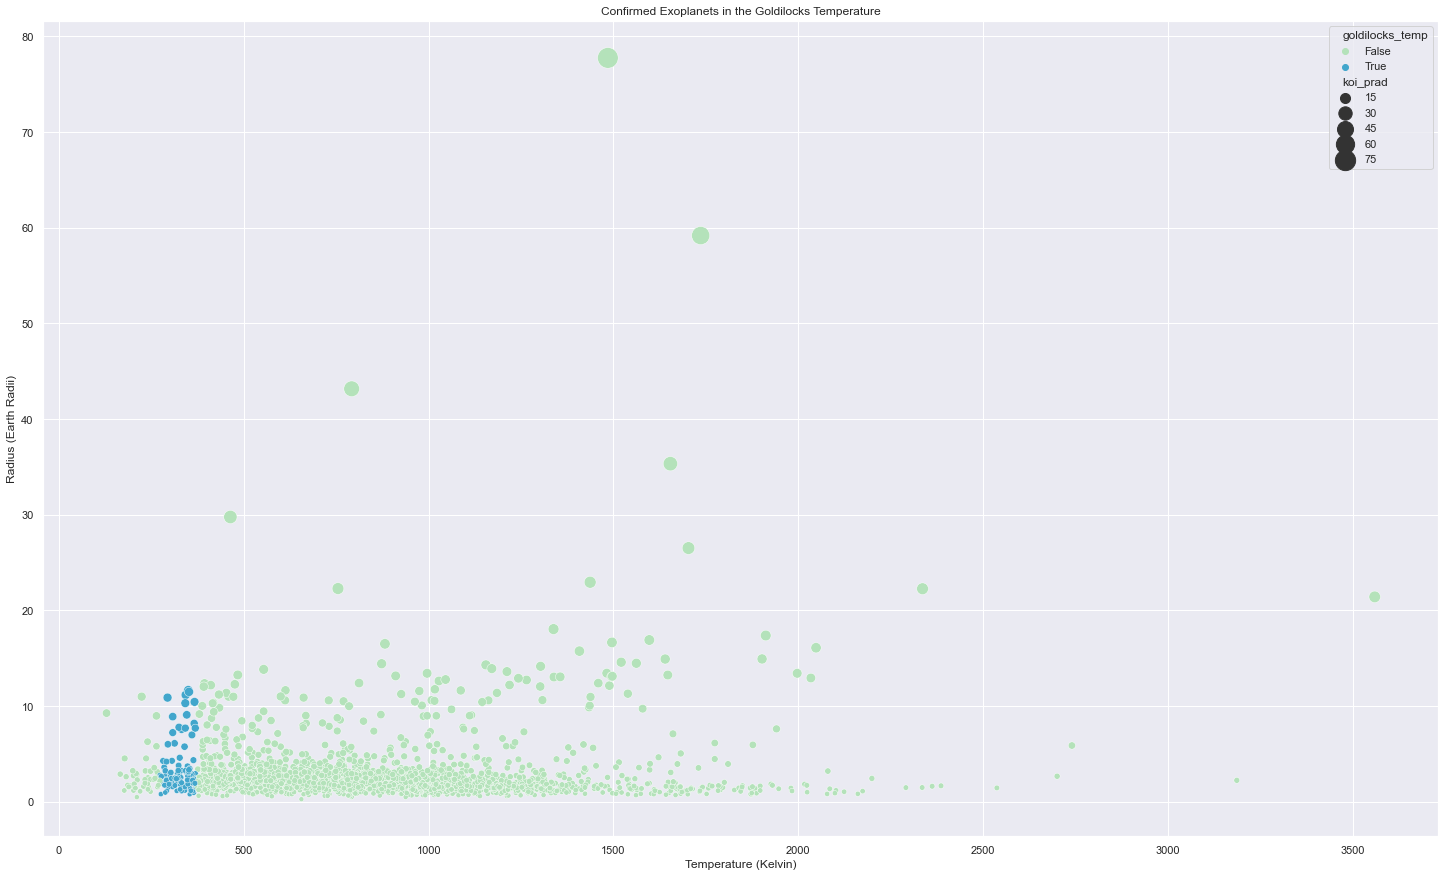

In [ ]:
sns.set(rc={'figure.figsize':(25,15)})
sns.scatterplot(
    data=dataset,        
    x="koi_teq",
    y="koi_prad",
    size="koi_prad", sizes=(25,425),    
    hue="goldilocks_temp", palette="GnBu",
)
plt.title('Exoplanets with the Goldilocks Temperature')
plt.xlabel('Temperature (Kelvin)')
plt.ylabel('Radius (Earth Radii)')
display()

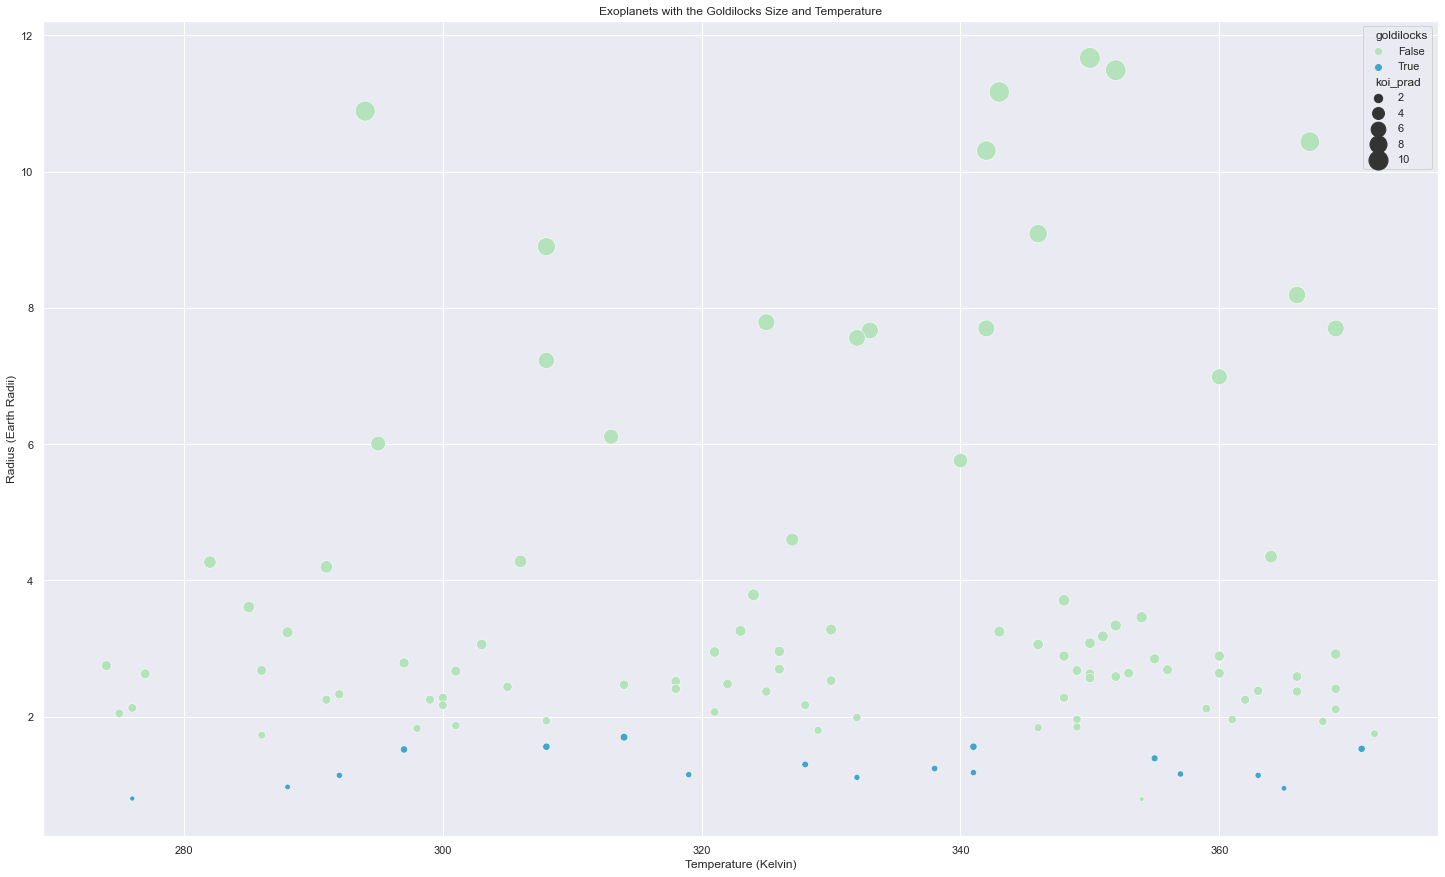

In [ ]:
sns.set(rc={'figure.figsize':(25,15)})
sns.scatterplot(
    data=dataset.query('goldilocks_temp==True'),        
    x="koi_teq",
    y="koi_prad",
    size="koi_prad", sizes=(25,425),    
    hue="goldilocks", palette="GnBu",
)
plt.title('Exoplanets with the Goldilocks Size and Temperature')
plt.xlabel('Temperature (Kelvin)')
plt.ylabel('Radius (Earth Radii)')
display()

This is a compiled list of the Exoplanets that are considered 'Goldilocks planets'.

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(   "Amount of hypothetically habitable exoplanets: " + str(dataset.query('goldilocks==True').shape[0]) )
    print(   "Amount of hypothetically habitable exoplanets: " + ", ".join( dataset.query('goldilocks==True')['kepler_name'].tolist()) )    
    display( dataset.query('goldilocks==True') )

Amount of hypothetically habitable exoplanets: 17
Amount of hypothetically habitable exoplanets: Kepler-1185 b, Kepler-138 d, Kepler-1512 b, Kepler-1646 b, Kepler-186 e, Kepler-220 e, Kepler-249 d, Kepler-296 A b, Kepler-296 A d, Kepler-367 c, Kepler-395 c, Kepler-437 b, Kepler-438 b, Kepler-445 c, Kepler-49 e, Kepler-54 d, Kepler-577 b


,kepler_name,koi_disposition,ra,dec,koi_period,koi_time0bk,koi_time0,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_fittype,koi_prad,koi_sma,koi_incl,koi_teq,koi_insol,koi_dor,koi_ldm_coeff1,koi_ldm_coeff2,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass,koi_sparprov,goldilocks_temp,goldilocks_size,goldilocks
kepoi_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
K02311.03,Kepler-1185 b,CONFIRMED,287.24118,39.332760,104.351962,190.102610,2455023.103,0.532,3.6950,243.8,0.014651,11.24570,LS+MCMC,1.39,0.4297,89.84,355.0,3.74,186.40,0.4035,0.2622,5650.0,4.546,0.02,0.870,0.971,stellar,True,True,True
K00314.02,Kepler-138 d,CONFIRMED,290.38150,43.292988,23.089022,171.007634,2455004.008,0.320,1.7012,598.3,0.022578,36.24543,LS+MCMC,1.24,0.1264,89.82,338.0,3.10,100.70,0.3402,0.3719,3846.0,4.738,-0.24,0.503,0.505,stellar,True,True,True
K03497.01,Kepler-1512 b,CONFIRMED,289.27451,44.470322,20.359719,134.291230,2454967.291,0.925,2.1521,345.7,0.021227,1.40140,LS+MCMC,0.80,0.1025,88.31,276.0,1.38,31.30,0.3573,0.3660,3419.0,4.904,0.04,0.344,0.346,stellar,True,True,True
K06863.01,Kepler-1646 b,CONFIRMED,287.52640,42.912899,4.485592,135.431720,2454968.432,0.442,0.8161,2265.0,0.044970,59.17312,LS+MCMC,0.95,0.0295,89.36,365.0,4.20,39.80,0.3573,0.3660,3236.0,5.097,0.00,0.193,0.169,stellar,True,True,True
K00571.04,Kepler-186 e,CONFIRMED,298.65271,43.955021,22.407778,153.798580,2454986.799,0.147,3.2881,661.3,0.023714,5.52889,LS+MCMC,1.15,0.1194,89.84,319.0,2.44,52.75,0.2405,0.4418,3751.0,4.800,-0.34,0.443,0.452,stellar,True,True,True
K00719.03,Kepler-220 e,CONFIRMED,291.50616,46.895741,45.902977,166.556670,2454999.557,0.303,5.0041,361.8,0.016968,2.82700,LS+MCMC,1.18,0.2166,89.74,341.0,3.19,68.00,0.6584,0.0833,4499.0,4.635,-0.26,0.639,0.643,stellar,True,True,True
K00899.03,Kepler-249 d,CONFIRMED,296.98505,43.658520,15.368457,147.389650,2454980.390,0.115,2.4714,756.1,0.024710,9.06854,LS+MCMC,1.11,0.0922,89.86,332.0,2.86,48.38,0.3573,0.3660,3561.0,4.855,0.00,0.411,0.440,stellar,True,True,True
K01422.03,Kepler-296 A b,CONFIRMED,286.54001,49.437328,10.864410,131.128330,2454964.128,0.763,1.8530,748.7,0.027366,4.69366,LS+MCMC,1.14,0.0704,88.58,363.0,4.09,30.80,0.3402,0.3775,3526.0,4.866,-0.08,0.383,0.394,stellar,True,True,True
K01422.02,Kepler-296 A d,CONFIRMED,286.54001,49.437328,19.850295,133.649330,2454966.649,0.217,2.8407,1607.5,0.036352,7.60188,LS+MCMC,1.52,0.1052,89.77,297.0,1.83,54.10,0.3402,0.3775,3526.0,4.866,-0.08,0.383,0.394,stellar,True,True,True


Plotting the Goldilocks Exoplanets alongside the Orbital Distance and Stellar Mass.

There is a solid direct connection between the Orbital Radius and the Stellar Mass of the Habitable Zone.

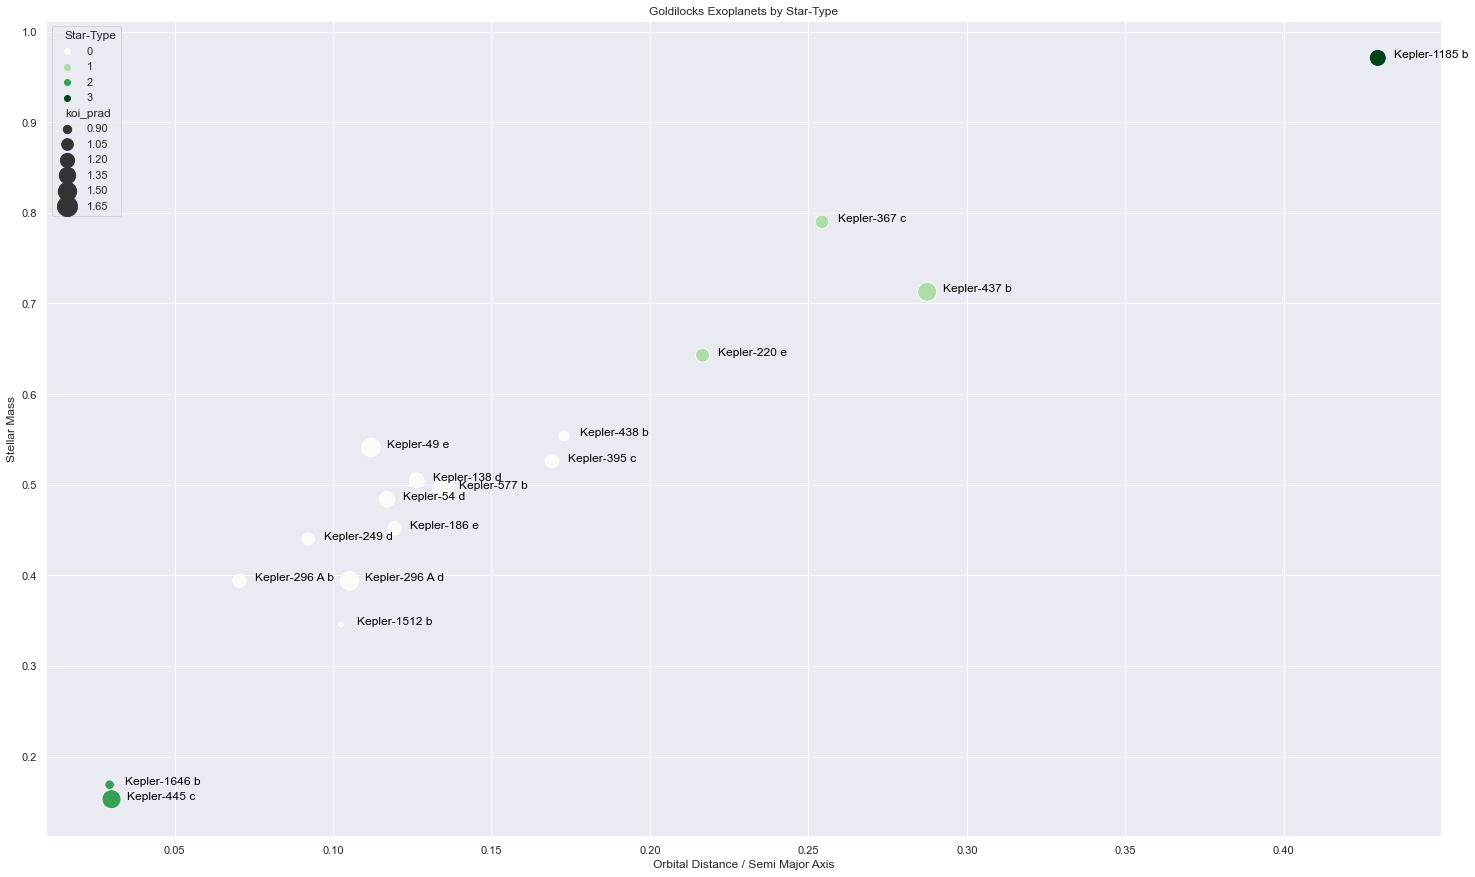

In [ ]:
df = dataset.query('goldilocks==True')
df['Star-Type'] = sklearn.cluster.KMeans(n_clusters=4).fit_predict(df[['koi_sma','koi_smass']])

plot = sns.scatterplot(
    data=df,        
    x="koi_sma",
    y="koi_smass",

    size="koi_prad", sizes=(25,425),    
    hue="Star-Type", palette="Greens",
#     hue="koi_teq", palette="RdBu_r",
)
for line in range(0,df.shape[0]):
     plot.text(
         df['koi_sma'][line]+0.005, 
         df['koi_smass'][line], 
         df['kepler_name'][line], 
         horizontalalignment='left', 
         size='medium', 
         color='black', 
         # weight='semibold'
     )

plt.title('Goldilocks Exoplanets by Star-Type')
plt.xlabel('Orbital Distance / Semi Major Axis')
plt.ylabel('Stellar Mass')
display()

Plotting Stellar Metallicity alongside Planetary Radius could offer deeper understanding of the groupings into planet structure, 
because rocky planets are more probale to come from high-metal stars.

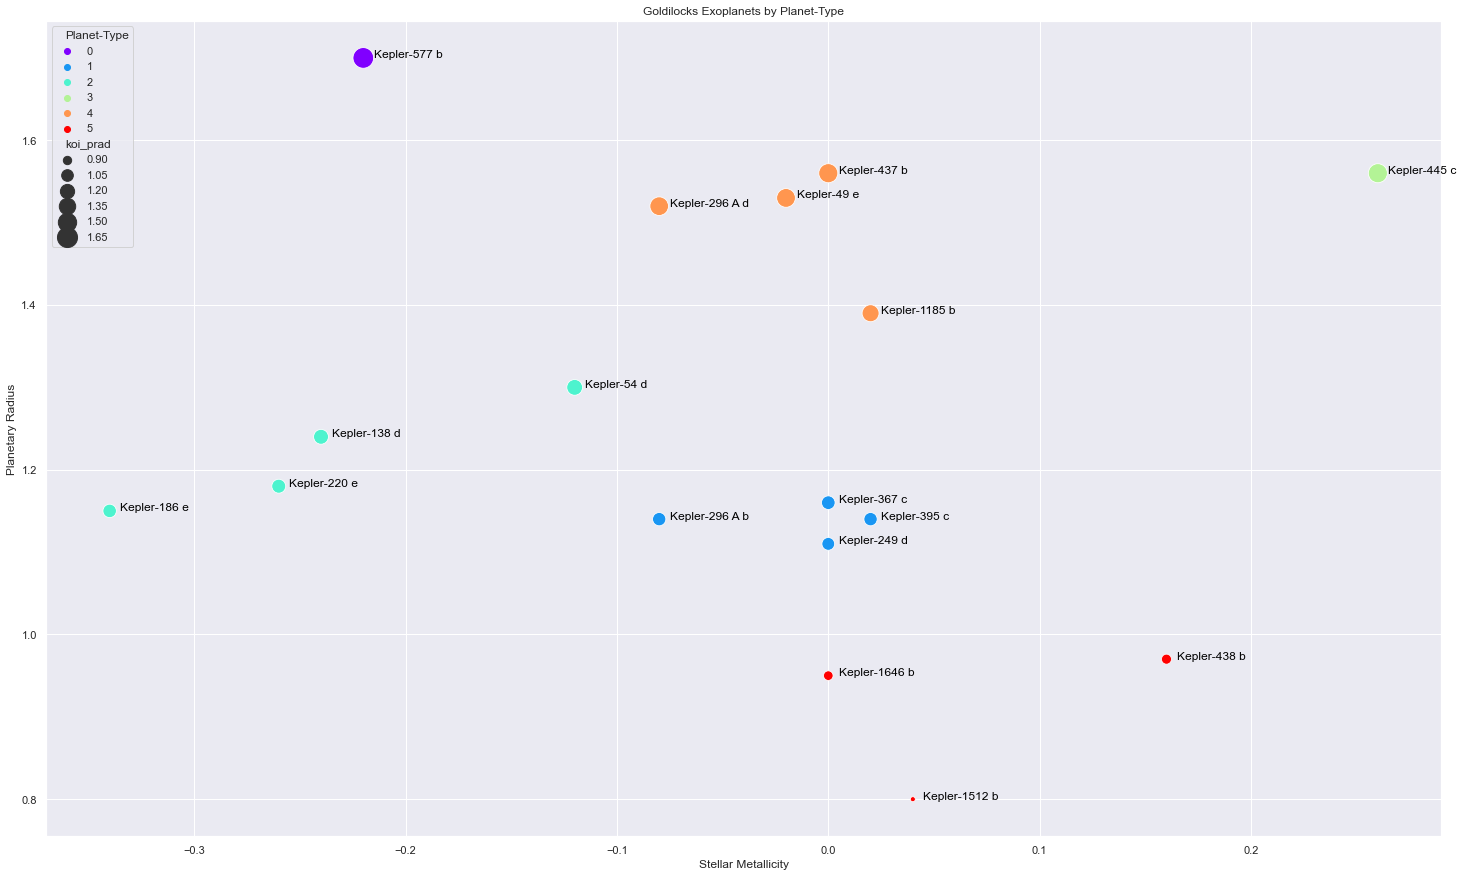

In [ ]:
df = dataset.query('goldilocks==True')
df['Planet-Type'] = sklearn.cluster.KMeans(n_clusters=6).fit_predict(df[['koi_smet','koi_prad']])

plot = sns.scatterplot(
    data=df,        
    x="koi_smet",
    y="koi_prad",

    size="koi_prad", sizes=(25,425),    
    hue="Planet-Type", palette="rainbow",
)
for line in range(0,df.shape[0]):
     plot.text(
         df['koi_smet'][line]+0.005, 
         df['koi_prad'][line], 
         df['kepler_name'][line], 
         horizontalalignment='left', 
         size='medium', 
         color='black', 
     )

plt.title('Goldilocks Exoplanets by Planet-Type')
plt.xlabel('Stellar Metallicity')
plt.ylabel('Planetary Radius')
display()

#### Starmap - Where are my habitable exoplanets?

Location of goldilocks exoplanets in the night sky

<AxesSubplot:xlabel='ra', ylabel='dec'>

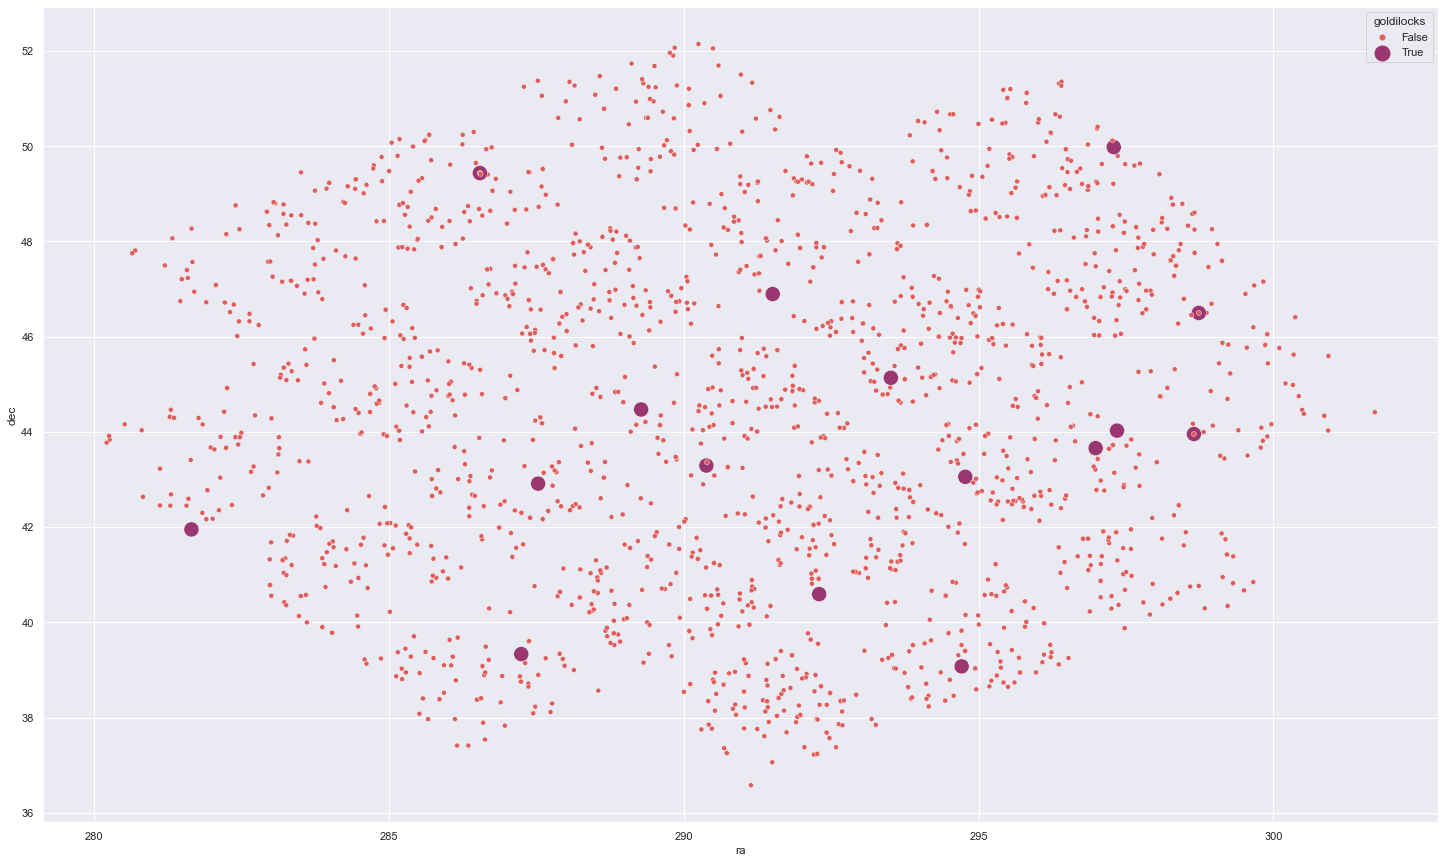

In [ ]:
display(
    sns.scatterplot(
        data=dataset,
        x="ra", 
        y="dec",
        sizes=(225,25),
        size="goldilocks", 
        hue="goldilocks", palette="flare",
    )
)